In [1]:
import pypsa
import pandas as pd
import logging
import numpy as np

In [2]:
def create_network(capacity):
    network = pypsa.Network()
    
    # Add a bus to the network.
    network.add("Bus","bus")
    
    # Create an empty network.
    network.set_snapshots(range(10))    
    
    # Add load to the bus.
    network.add("Load","load",bus="bus",p_set=[6000,1200,4000,3000,5000,0,1000,5500,3500,6000])
    
    
    max_capacity = [network.loads_t.p_set.max() if unit==-1 else unit for unit in capacity]


    # Add a coal power plant to the bus.
    network.add("Generator","coal",bus="bus",
           committable=True,
           p_min_pu=0.0,
           marginal_cost=15,
           capital_cost= 80,
           p_nom_extendable=True,
           p_nom_min=capacity[0],
           p_nom_max=max_capacity[0])

    # Add a gas power plant to the bus.
    network.add("Generator","gas",bus="bus",
           committable=True,
           marginal_cost=20,
           capital_cost=75,
           p_min_pu=0,
           p_nom_extendable=True,
           p_nom_min=capacity[1],
           p_nom_max=max_capacity[1])

    # Add a 2nd gas power plant to the bus.
    network.add("Generator","bio",bus="bus",
           committable=True,
           marginal_cost=18,
           capital_cost = 80,
           p_min_pu=0,
           p_nom_extendable=True,
           p_nom_min=capacity[2],
           p_nom_max=max_capacity[2])



    return network

In [3]:
network = create_network([-1,-1,-1])

In [4]:
# Initial solution of network, with non MGA objective function 
network.lopf(network.snapshots,solver_name='gurobi')
# Saving the value of the old objective function.
old_objective_value = network.model.objective()
print('old objective valeu: ' + str(old_objective_value))

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi
INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 1008000.0
  Upper bound: 1008000.0
  Number of objectives: 1
  Number of constraints: 81
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 131
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimali

In [5]:
network.generators

attribute,bus,control,type,p_nom,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,p_set,...,start_up_cost,shut_down_cost,min_up_time,min_down_time,initial_status,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,p_nom_opt
coal,bus,Slack,,0.0,True,-1.0,6000.0,0.0,1.0,0.0,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,6000.0
gas,bus,PQ,,0.0,True,-1.0,6000.0,0.0,1.0,0.0,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0
bio,bus,PQ,,0.0,True,-1.0,6000.0,0.0,1.0,0.0,...,0.0,0.0,0,0,1,NaN,NaN,1.0,1.0,0.0


### Adding MGA constraint 

In [6]:
def constraint_functionality(network, snapshots,  MGA_slack = 0.05):
    import pyomo.environ as pyomo_env
    #MGA_slack = 0.1

    network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
                                                  (1 + MGA_slack) * old_objective_value)

    print((1 + MGA_slack) * old_objective_value)

In [7]:
def update_network(network,capacity):
    
    max_capacity = [network.loads_t.p_set.max() if unit==-1 else unit for unit in capacity]
    
    network.generators.at['coal','p_nom_min'] = capacity[0]
    network.generators.at['gas','p_nom_min'] = capacity[1]
    network.generators.at['bio','p_nom_min'] = capacity[2]
    
    network.generators.at['coal','p_nom_max'] = max_capacity[0]
    network.generators.at['gas','p_nom_max'] = max_capacity[1]
    network.generators.at['bio','p_nom_max'] = max_capacity[2]
    
    return network

In [8]:
def test_point(network,variables):

    pypsa.pf.logger.setLevel(logging.ERROR)
    network = update_network(network,variables)
    
    out = network.lopf(network.snapshots,\
                 solver_name='gurobi',\
                 skip_pre=True,\
                 extra_functionality=lambda network,\
                 snapshots: constraint_functionality(network, snapshots, MGA_slack),
                 solver_options = {'threads':8})

    if str(network.results['Solver'].status) == 'ok' and network.generators.p_nom_opt[:].sum()==6000:
        feasable = True
    else : 
        feasable = False
        
    variables_out = list(network.generators.p_nom_opt)

    return(feasable,variables_out)
    

### Finding max and min values 

In [9]:
import pyomo.environ as pyomo_env
# Defining exstra functionality, that updates the objective function of the network
def maxmin_functionality(network, snapshots,  MGA_slack = 0.05, counter = 0,test = [0,0,0]):
    # Identify the nonzero decision variables that should enter the MGA objective function.
    
    MGA_objective = 0
    variables = [gen_p for gen_p in network.model.generator_p_nom]
    gen_p = variables[int(counter/2)]
    MGA_objective += network.model.generator_p_nom[gen_p]
    if counter%2 == 0 :
        MGA_objective = -MGA_objective
    print(MGA_objective)

    # Add the new MGA objective function to the model.
    network.model.mga_objective = pyomo_env.Objective(expr=MGA_objective)
    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()
    # Add the MGA slack constraint.
    #print('old objective value ',old_objective_value)
    network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
                                          (1 + MGA_slack) * old_objective_value)

In [10]:
test = 0
sum([network.model.generator_p_nom[gen_p] for gen_p in network.model.generator_p_nom])

In [11]:
import pyomo.environ as pyomo_env
# Defining exstra functionality, that updates the objective function of the network
def maxmin_functionality2(network, snapshots,  MGA_slack = 0.05, counter = 0,test=[0,0,0]):
    # Identify the nonzero decision variables that should enter the MGA objective function.
    
    MGA_objective = 0
    variables = [gen_p for gen_p in network.model.generator_p_nom]
    gen_p1 = network.model.generator_p_nom[variables[0]]*test[int(counter/2)][0]
    gen_p2 = network.model.generator_p_nom[variables[1]]*test[int(counter/2)][1]
    gen_p3 = network.model.generator_p_nom[variables[2]]*test[int(counter/2)][2]
    MGA_objective += gen_p1 + gen_p2 + gen_p3 
    if counter%2 == 0 :
        MGA_objective = -MGA_objective
    print(MGA_objective)

    # Add the new MGA objective function to the model.
    network.model.mga_objective = pyomo_env.Objective(expr=MGA_objective)
    # Deactivate the old objective function and activate the MGA objective function.
    network.model.objective.deactivate()
    network.model.mga_objective.activate()
    # Add the MGA slack constraint.
    #print('old objective value ',old_objective_value)
    network.model.mga_constraint = pyomo_env.Constraint(expr=network.model.objective.expr <= 
                                          (1 + MGA_slack) * old_objective_value)
    
    network.model.constraint1 = pyomo_env.Constraint(expr=sum([network.model.generator_p_nom[gen_p] for gen_p in network.model.generator_p_nom])<=6000)

In [12]:
counter = 1
MGA_slack = 0.1

network= update_network(network,[-1,-1,-1])

N = 3
test = 1*((np.arange(2**N)[:,None] & (1 << np.arange(N))) > 0)

network.solutions = []

for counter in range(len(test)*2):  #(len(network.generators)*2):
    print(counter)
    network.lopf(network.snapshots,\
                         solver_name='gurobi',\
                         extra_functionality=lambda network,\
                         snapshots: maxmin_functionality2(network, snapshots, MGA_slack,counter,test))
    network.solutions.append(network.copy())

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


0
0
    solver failure.


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


1
0
    solver failure.


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


2
- generator_p_nom[coal]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: -6000.0
  Upper bound: -6000.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


3
generator_p_nom[coal]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 159.25925925925927
  Upper bound: 159.25925925925927
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


4
- generator_p_nom[gas]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: -4851.428571428572
  Upper bound: -4851.428571428572
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


5
generator_p_nom[gas]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


6
- (generator_p_nom[coal] + generator_p_nom[gas])


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: -6000.0
  Upper bound: -6000.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


7
generator_p_nom[coal] + generator_p_nom[gas]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 177.77777777777777
  Upper bound: 177.77777777777777
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


8
- generator_p_nom[bio]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: -5822.222222222223
  Upper bound: -5822.222222222223
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


9
generator_p_nom[bio]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


10
- (generator_p_nom[coal] + generator_p_nom[bio])


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: -6000.0
  Upper bound: -6000.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.


11


INFO:pypsa.opf:Solving model using gurobi


generator_p_nom[coal] + generator_p_nom[bio]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 1148.5714285714284
  Upper bound: 1148.5714285714284
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


12
- (generator_p_nom[gas] + generator_p_nom[bio])


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: -5840.740740740741
  Upper bound: -5840.740740740741
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


13
generator_p_nom[gas] + generator_p_nom[bio]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 0.0
  Upper bound: 0.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (subject 

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


14
- (generator_p_nom[coal] + generator_p_nom[gas] + generator_p_nom[bio])


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: -6000.0
  Upper bound: -6000.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (

INFO:pypsa.pf:Slack bus for sub-network 0 is bus
INFO:pypsa.opf:Performed preliminary steps
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


15
generator_p_nom[coal] + generator_p_nom[gas] + generator_p_nom[bio]


INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 6000.0
  Upper bound: 6000.0
  Number of objectives: 1
  Number of constraints: 83
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 167
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was solved to optimality (su

In [13]:

coal_max = (float(network.solutions[0].generators.loc['coal'].p_nom_opt))
coal_min = (float(network.solutions[1].generators.loc['coal'].p_nom_opt))
gas_max =(float(network.solutions[2].generators.loc['gas'].p_nom_opt))
gas_min = (float(network.solutions[3].generators.loc['gas'].p_nom_opt))
bio_max = (float(network.solutions[4].generators.loc['bio'].p_nom_opt))
bio_min = (float(network.solutions[5].generators.loc['bio'].p_nom_opt))

In [14]:
max_min_points = []
for i in range(len(network.solutions)):
    test = []
    for j in range(3):
        test.append(network.solutions[i].generators.p_nom_opt[j])
    max_min_points.append(test)
max_min_points

[[1148.5714285714284, 4851.428571428572, 0.0],
 [1148.5714285714284, 4851.428571428572, 0.0],
 [6000.0, 0.0, 0.0],
 [159.25925925925927, 500.0, 5340.740740740741],
 [1148.5714285714284, 4851.428571428572, 0.0],
 [6000.0, 0.0, 0.0],
 [6000.0, 0.0, 0.0],
 [177.77777777777777, 0.0, 5822.222222222223],
 [177.77777777777777, 0.0, 5822.222222222223],
 [1148.5714285714284, 4851.428571428572, 0.0],
 [177.77777777777737, 0.0, 5822.222222222223],
 [1148.5714285714284, 4851.428571428572, 0.0],
 [159.25925925925927, 500.0, 5340.740740740741],
 [6000.0, 0.0, 0.0],
 [177.77777777777737, 0.0, 5822.222222222223],
 [1148.5714285714284, 4851.428571428572, 0.0]]

In [15]:
[sum(test)for test in max_min_points]

[6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0,
 6000.0]

In [16]:
for i in range(len(network.solutions)):
    print(network.solutions[i].generators.p_nom)

coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name: p_nom, dtype: float64
coal    0.0
gas     0.0
bio     0.0
Name

In [17]:
network.model.generator_p

### Bruteforcing descicion space 

In [18]:
class grid :
    pass

dens = 11
grid.coal,grid.gas  = np.meshgrid(np.linspace(coal_min,coal_max,dens),np.linspace(gas_min,gas_max,dens))

grid.coal = grid.coal.reshape(dens**2)
grid.gas = grid.gas.reshape(dens**2)

mid_point = [grid.coal.mean(),grid.gas.mean()]
dist_to_mid=np.sqrt((abs(grid.coal-grid.coal.mean())+abs(grid.gas-grid.gas.mean()))**2)
sort_idx = np.argsort(-dist_to_mid)
grid.coal = grid.coal[sort_idx]
grid.gas = grid.gas[sort_idx]
#y2 = y2.reshape(11**2)

(0, 8000)

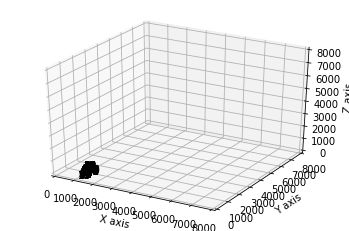

In [19]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.gca(projection='3d')
grid.test = []
# Plot defining corner points
for i in range(len(grid.coal)):
    point3 = [grid.coal[i],grid.gas[i]]
    #if not any([isBetween(point1,point2,point3) for point1 in grid.test for point2 in grid.test]):
    ax.text(grid.coal[i], grid.gas[i], grid.gas[i], str(i))
    grid.test.append(point3)
ax.set_xlabel('X axis')
ax.set_ylabel('Y axis')
ax.set_zlabel('Z axis')
ax.set_xlim(0, 8000)
ax.set_ylim(0, 8000)
ax.set_zlim(0, 8000)

#plt.show()

In [20]:
def isBetween(a, b, c):
    crossproduct = (c[1] - a[1]) * (b[0] - a[0]) - (c[0] - a[0]) * (b[1] - a[1])
    dotproduct = (c[0] - a[0]) * (b[0] - a[0]) + (c[1] - a[1])*(b[1] - a[1])
    # compare versus epsilon for floating point values, or != 0 if using integers
    #print(abs(crossproduct))
    epsilon = np.sqrt(dotproduct)
    if abs(crossproduct) > epsilon:
        return False
    
    
    #print(np.sqrt(dotproduct))
    if dotproduct < 0:
        return False

    squaredlengthba = (b[0] - a[0])*(b[0] - a[0]) + (b[1] - a[1])*(b[1] - a[1])
    if dotproduct > squaredlengthba:
        return False
    
    if a == b:
        return False

    return True

In [21]:
test = []
grid.feasable = []
grid.infeasable = []
simulations = 0

for coal,gas in zip(grid.coal,grid.gas):
    
    point3 = [coal,gas]
    
    between_feasable = any([isBetween(point1,point2,point3) for point1 in grid.feasable for point2 in grid.feasable])
    between_infeasable = any([isBetween(point1,point2,point3) for point1 in grid.infeasable for point2 in grid.infeasable])
    
    if (not between_feasable) :#and (not between_infeasable) :
        is_good , variables_out = test_point(network,[coal,gas,-1])
        simulations += 1
        if is_good:
            grid.feasable.append(variables_out)
        else :
            grid.infeasable.append([coal,gas,6000-gas-coal])

INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


1108800.0


INFO:pypsa.opf:Optimization successful
INFO:pypsa.opf:Building pyomo model using `angles` formulation
Index(['coal', 'gas', 'bio'], dtype='object')
Currently PyPSA cannot do both these functions, so PyPSA is choosing investment optimisation for these generators.
INFO:pypsa.opf:Solving model using gurobi


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 1082534.285714286
  Upper bound: 1082534.285714286
  Number of objectives: 1
  Number of constraints: 82
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 164
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was so

INFO:pypsa.opf:Optimization successful


# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Name: x44
  Lower bound: 1083034.285714286
  Upper bound: 1083034.285714286
  Number of objectives: 1
  Number of constraints: 82
  Number of variables: 44
  Number of binary variables: 0
  Number of integer variables: 0
  Number of continuous variables: 44
  Number of nonzeros: 164
  Sense: minimize
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Return code: 0
  Message: Model was solved to optimality (subject to tolerances), and an optimal solution is available.
  Termination condition: optimal
  Termination message: Model was so

In [22]:
simulations

2

In [44]:
%matplotlib widget
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#for is_blue,i in zip(test,range(len(test))):
#    if is_blue:
#        ax.plot([grid.test[i][0]], [grid.test[i][1]], [grid.test[i][2]], "bo")
    #else :
        #ax.plot([grid.test[i][0]], [grid.test[i][1]], [grid.test[i][2]], "ro")
# Make axis label

for i in range(len(grid.infeasable)):
    ax.plot([grid.infeasable[i][0]],[grid.infeasable[i][1]],[grid.infeasable[i][2]], "ro")

for i in range(len(grid.feasable)):
    ax.plot([grid.feasable[i][0]],[grid.feasable[i][1]],[grid.feasable[i][2]], "bo")
    
for i in range(len(max_min_points)):
    ax.plot([max_min_points[i][0]],[max_min_points[i][1]],[max_min_points[i][2]], "go")


ax.set_xlabel('Coal')
ax.set_ylabel('Gas')
ax.set_zlabel('Bio')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'Bio')

In [24]:
coal_min

1148.5714285714284

### Trying stuff out with convex hull's

In [25]:

import itertools
max_min_points.sort()
max_min_points=list(max_min_points for max_min_points,_ in itertools.groupby(max_min_points))
max_min_points

[[159.25925925925927, 500.0, 5340.740740740741],
 [177.77777777777737, 0.0, 5822.222222222223],
 [177.77777777777777, 0.0, 5822.222222222223],
 [1148.5714285714284, 4851.428571428572, 0.0],
 [6000.0, 0.0, 0.0]]

In [26]:
from sklearn.decomposition import PCA
pca = PCA()
x_pca = pca.fit_transform(max_min_points)
x_pca

array([[-2.44463978e+03,  1.14992287e+02,  6.50764309e-13],
       [-2.95580317e+03, -3.54985725e+02, -3.51361812e-13],
       [-2.95580317e+03, -3.54985725e+02, -8.69048154e-14],
       [ 3.53975449e+03,  3.66804816e+03, -7.07030623e-15],
       [ 4.81649163e+03, -3.07306900e+03,  6.65383852e-14]])

In [27]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

for i in range(len(x_pca)):
    ax.plot([x_pca[i][0]],[x_pca[i][1]],[0], "bo")


ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0.5, 0, 'z')

In [28]:
explained_variance = pca.explained_variance_ratio_
explained_variance

array([7.18690014e-01, 2.81309986e-01, 6.78851803e-33])

In [29]:
points = np.array(max_min_points)
points[:,0:2]

array([[ 159.25925926,  500.        ],
       [ 177.77777778,    0.        ],
       [ 177.77777778,    0.        ],
       [1148.57142857, 4851.42857143],
       [6000.        ,    0.        ]])

In [30]:
from scipy.spatial import ConvexHull, convex_hull_plot_2d
points = np.array(max_min_points)
hull = ConvexHull(points[:,0:2])



In [31]:
hull.volume

14410666.66666667

In [32]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot defining corner points
ax.plot(points.T[0], points.T[1], points.T[2], "ko")

# 12 = 2 * 6 faces are the simplices (2 simplices per square face)
for s in hull.simplices:
    
    s = np.append(s, s[0])  # Here we cycle back to the first coordinate
    ax.plot(points[s, 0], points[s, 1], points[s, 2], "r-")

# Make axis label
for i in ["x", "y", "z"]:
    eval("ax.set_{:s}label('{:s}')".format(i, i))

plt.show()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [33]:
hull.simplices

array([[3, 0],
       [3, 4],
       [1, 0],
       [1, 4]], dtype=int32)

In [34]:
2**90

1237940039285380274899124224

In [35]:
import trimesh

In [36]:
np.linspace(1,len(points),len(points))

array([1., 2., 3., 4., 5.])

In [37]:
mesh = trimesh.Trimesh(vertices=points,
                       faces=[[0, 1, 2,3]])


INFO:trimesh:triangulating quad faces


In [38]:
mesh.process()

In [39]:
mesh = mesh.subdivide()

In [40]:
mesh.vertices

TrackedArray([[ 159.25925926,  500.        , 5340.74074074],
              [ 653.91534392, 2675.71428571, 2670.37037037],
              [1148.57142857, 4851.42857143,    0.        ],
              [ 168.51851852,  250.        , 5581.48148148],
              [ 663.17460317, 2425.71428571, 2911.11111111],
              [ 177.77777778,    0.        , 5822.22222222]])

In [41]:
for facet in mesh.facets:
    mesh.visual.face_colors[facet] = trimesh.visual.random_color()

# preview mesh in an opengl window if you installed pyglet with pip
mesh.show()

C:\Users\Tim\Anaconda3\lib\site-packages\IPython\core\display.py:689: UserWarning:

Consider using IPython.display.IFrame instead



In [42]:
points

array([[ 159.25925926,  500.        , 5340.74074074],
       [ 177.77777778,    0.        , 5822.22222222],
       [ 177.77777778,    0.        , 5822.22222222],
       [1148.57142857, 4851.42857143,    0.        ],
       [6000.        ,    0.        ,    0.        ]])

In [43]:
trimesh.creation()

TypeError: 'module' object is not callable